**Importaciones**

In [1]:
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings


# **Extracción**

In [2]:
# --- Conexión PostgreSQL ---
pg_user = "transformed"
pg_password = "etl25"
pg_host = "localhost"   # usa 'postgres-dw' si corres dentro de Docker
pg_port = "5432"
pg_db = "icfes_transformed"

pg_url = f"postgresql+psycopg2://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_db}"
pg_engine = create_engine(pg_url)

# --- Leer tabla a DataFrame ---
data_transformed = pd.read_sql("SELECT * FROM data_transformed", con=pg_engine)

print("✅ Datos cargados desde Postgres:", data_transformed.shape)

✅ Datos cargados desde Postgres: (626339, 53)


In [3]:
print(data_transformed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626339 entries, 0 to 626338
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   periodo                        626339 non-null  int64  
 1   estu_estudiante                626339 non-null  object 
 2   cole_area_ubicacion            626339 non-null  object 
 3   cole_bilingue                  626339 non-null  int64  
 4   cole_calendario                626339 non-null  object 
 5   cole_caracter                  626339 non-null  object 
 6   cole_depto_ubicacion           626339 non-null  object 
 7   cole_genero                    626339 non-null  object 
 8   cole_jornada                   626339 non-null  object 
 9   cole_mcpio_ubicacion           626339 non-null  object 
 10  cole_naturaleza                626339 non-null  object 
 11  desemp_c_naturales             626339 non-null  int64  
 12  desemp_ingles                 

# **Gráficos**

**Distribución de Puntajes**

La siguiente gráfica muestra un **comportamiento normal en el puntaje global**, con un mínimo **sesgo a la derecha**, pero aún así, los valores extremos son relativamente pocos y no rompen la distribución normal o la forma de campana. Pero **en inglés** podemos ver que la distribución es bastante frecuente en los puntajes bajos y se abre con una cola larga hacia la derecha, lo que genera una cantidad mucho mayor de valores atípicos. Esto nos dice que **los casi 10.000 outliers detectados en el análisis previo, no son errores raros, sino que reflejan la dispersión de los datos en esta prueba, donde claramente, el desempeño de los estudiantes es muy distinto.**

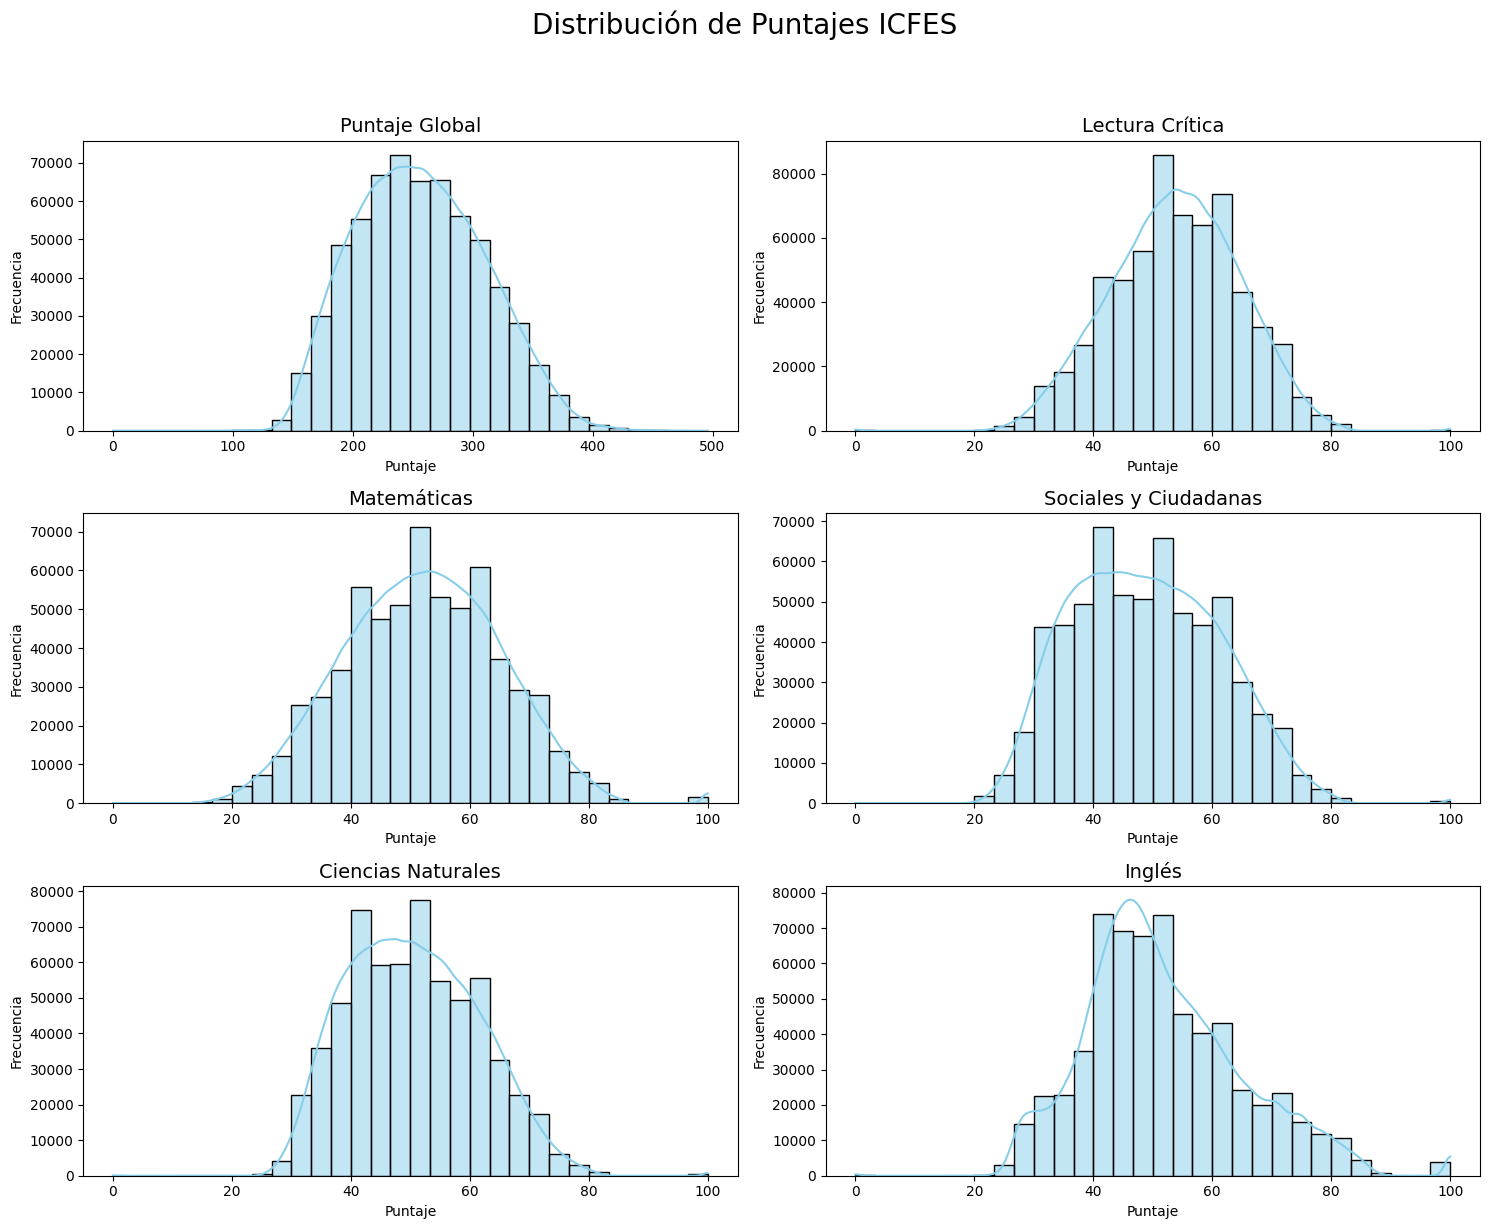

In [4]:
# --- Variables de interés (puntajes y percentiles) ---
vars = {
    "punt_global": "Puntaje Global",
    "punt_lectura_critica": "Lectura Crítica",
    "punt_matematicas": "Matemáticas",
    "punt_sociales_ciudadanas": "Sociales y Ciudadanas",
    "punt_c_naturales": "Ciencias Naturales",
    "punt_ingles": "Inglés"
}

# --- Crear la figura y los subgráficos ---
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()

# --- Iterar sobre las variables y graficar ---
for i, col in enumerate(vars.keys()):
    sns.histplot(
        data=data_transformed,
        x=col,
        kde=True,
        bins=30,
        ax=axes[i],
        color="skyblue"
    )
    axes[i].set_title(vars[col], fontsize=14)
    axes[i].set_xlabel("Puntaje")
    axes[i].set_ylabel("Frecuencia")

# --- Título principal ---
plt.suptitle("Distribución de Puntajes ICFES", fontsize=20, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


**Puntaje global entre periodos**

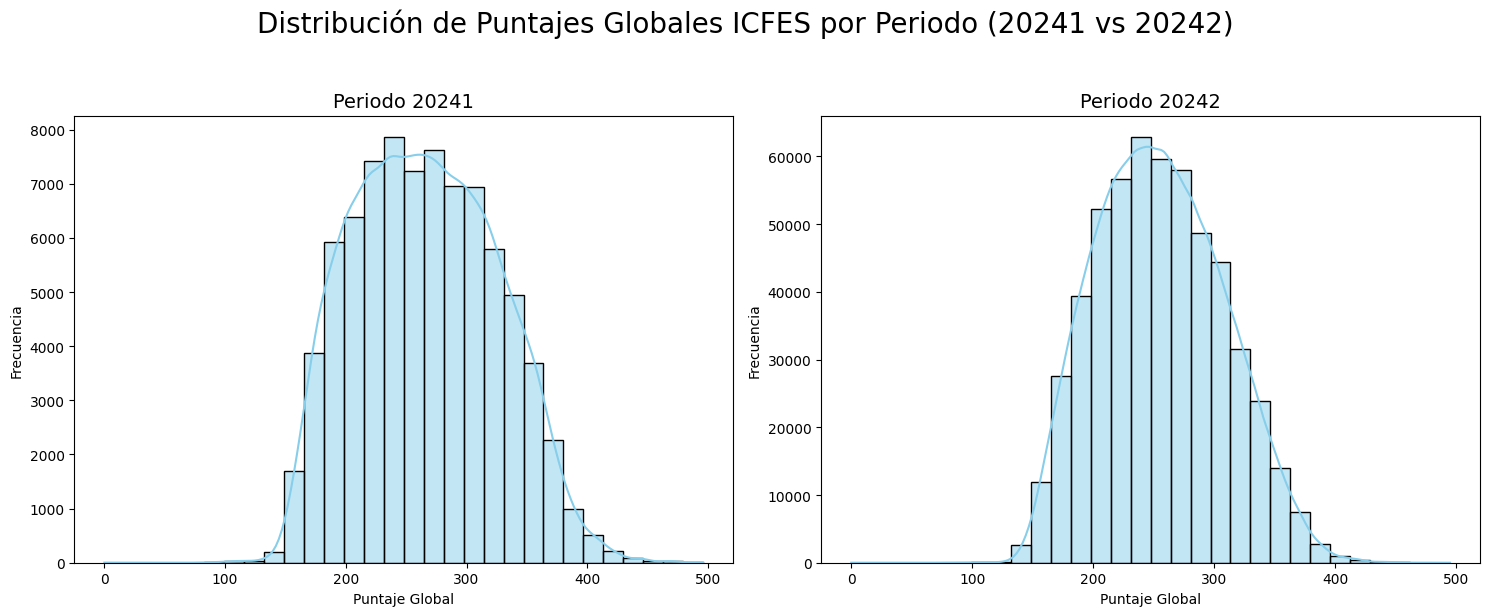

In [8]:
periodos = [20241, 20242]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes = axes.flatten()

for i, periodo in enumerate(periodos):
    data_periodo = data_transformed[data_transformed['periodo'] == periodo]
    
    sns.histplot(
        data=data_periodo,
        x="punt_global",
        kde=True,
        bins=30,
        ax=axes[i],
        color='skyblue'
    )
    axes[i].set_title(f"Periodo {periodo}", fontsize=14)
    axes[i].set_xlabel("Puntaje Global")
    axes[i].set_ylabel("Frecuencia")

plt.suptitle("Distribución de Puntajes Globales ICFES por Periodo (20241 vs 20242)", fontsize=20, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

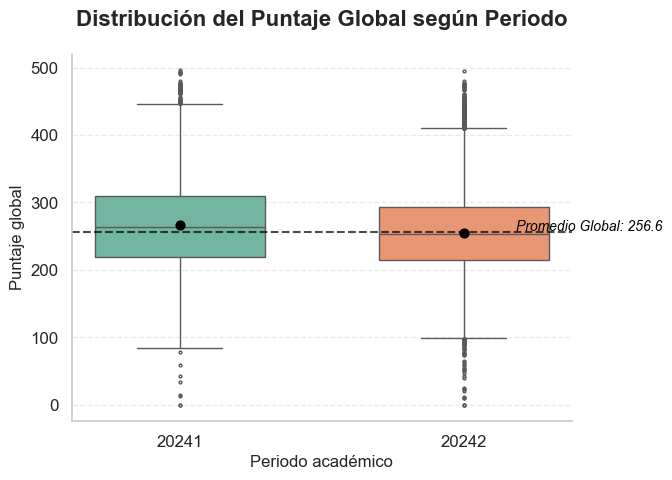

In [9]:
sns.set_theme(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(7, 5))

# Ordenar periodos (numéricamente)
order = sorted(data_transformed["periodo"].unique())

# Boxplot
ax = sns.boxplot(
    x="periodo",
    y="punt_global",
    hue="periodo",      
    data=data_transformed,
    palette="Set2",    
    order=order,
    width=0.6,
    fliersize=2,
    legend=False
)

# Línea de referencia con promedio global
mean_global = data_transformed["punt_global"].mean()
ax.axhline(mean_global, ls="--", color="black", alpha=0.7)
ax.text(len(order)-0.3, mean_global+2,
        f"Promedio Global: {mean_global:.1f}",
        color="black", fontsize=10, ha="right", style="italic")

# Media de cada grupo como punto negro
group_means = data_transformed.groupby("periodo")["punt_global"].mean()
for i, val in enumerate(order):
    ax.scatter(i, group_means[val], color="black", s=40, zorder=3, label="Media" if i==0 else "")

# Estética
plt.title("Distribución del Puntaje Global según Periodo", fontsize=16, weight="bold", pad=20)
plt.xlabel("Periodo académico", fontsize=12)
plt.ylabel("Puntaje global", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4, axis="y")
sns.despine()

plt.tight_layout()
plt.show()

En el Boxplot podemos ver un **comportamiento parecido en los resultados de las pruebas de los dos periodos**, donde **2024-1** es ligeramente superior al realizado el segundo semestre del año, así mismo, hay menos valores raros, pero con un poco más de dispersión en constraste con el periodo **2024-2**,donde los datos están bastante concentrados al rededor de la media.

**Puntaje según condiciones familiares**

**Puntaje Global Por Municipio**

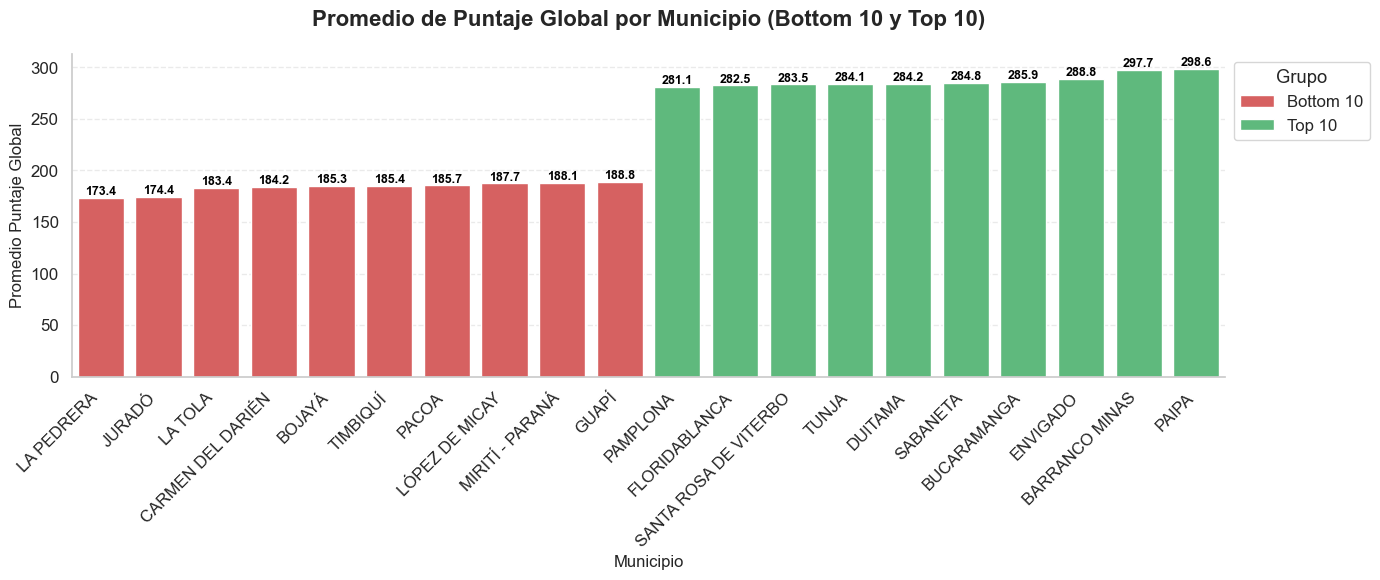

In [10]:
# Agrupar por municipio y calcular promedio del puntaje global
municipio_mean = data_transformed.groupby("estu_mcpio_presentacion")["punt_global"].mean().sort_values()

# Seleccionar los 10 con menor y 10 con mayor promedio
top_bottom = pd.concat([municipio_mean.head(10), municipio_mean.tail(10)])

# Crear un DataFrame para graficar
df_plot = top_bottom.reset_index()
df_plot.columns = ["municipio", "puntaje_promedio"]

# Etiqueta para diferenciar top y bottom
df_plot["grupo"] = ["Bottom 10"] * 10 + ["Top 10"] * 10

# Ordenar de menor a mayor
df_plot = df_plot.sort_values("puntaje_promedio")

plt.figure(figsize=(14, 6))
ax = sns.barplot(
    x="municipio", 
    y="puntaje_promedio", 
    hue="grupo",
    data=df_plot,
    palette={"Bottom 10": "#E94E4E", "Top 10": "#50C878"},
    dodge=False  # evita barras separadas
)

# Etiquetas con valores
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{p.get_height():.1f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha="center", va="bottom", fontsize=9, weight="bold", color="black")

# Estética
plt.title("Promedio de Puntaje Global por Municipio (Bottom 10 y Top 10)", fontsize=16, weight="bold", pad=20)
plt.xlabel("Municipio", fontsize=12)
plt.ylabel("Promedio Puntaje Global", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(title="Grupo", loc="upper left", bbox_to_anchor=(1, 1))
sns.despine()

plt.tight_layout()
plt.show()


Acá la diferencia es bastante notoria. **En los municipios con los puntajes más bajos se ubican zonas apartadas**, muchas de ellas con condiciones socioeconómicas complejas y limitaciones en el acceso a una educación de calidad. En contraste, **los municipios que lideran el promedio global corresponden a lugares con mayor desarrollo**, donde las oportunidades educativas suelen ser mayores.


**Distribución de puntajes según la naturaleza del colegio**


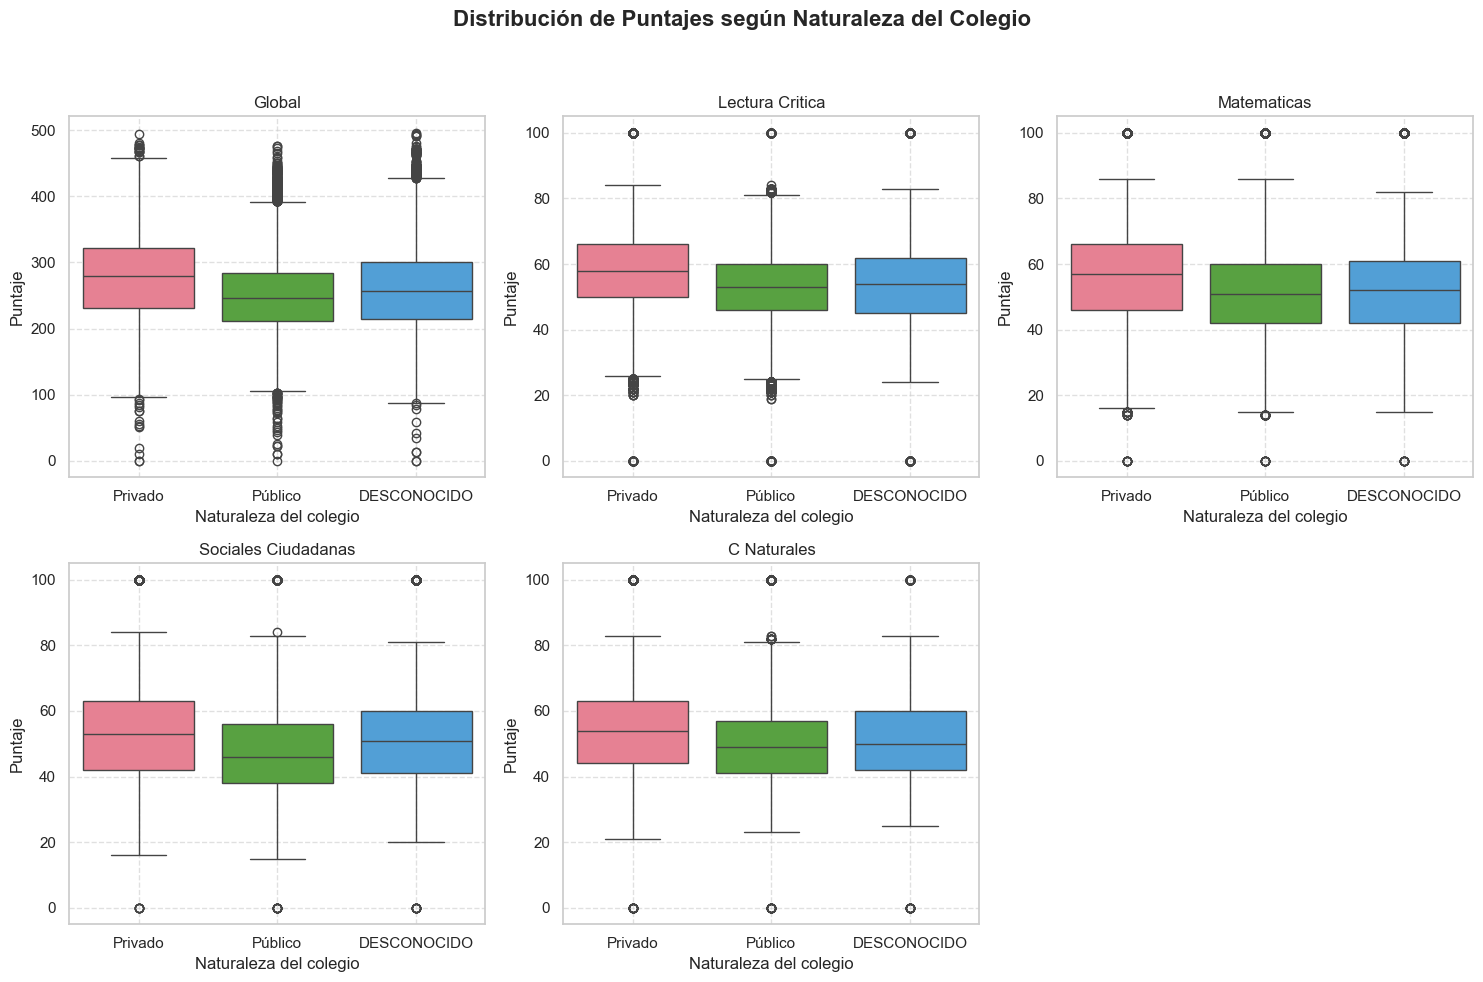

In [11]:
sns.set_theme(style="whitegrid")

# Variables de puntajes a comparar
puntajes = [
    "punt_global",
    "punt_lectura_critica",
    "punt_matematicas",
    "punt_sociales_ciudadanas",
    "punt_c_naturales"
]

# Mapeo de valores de naturaleza
data_plot = data_transformed.copy()
data_plot["cole_naturaleza"] = data_plot["cole_naturaleza"].replace({
    "OFICIAL": "Público",
    "NO OFICIAL": "Privado"
})

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, puntaje in enumerate(puntajes):
    sns.boxplot(
        x="cole_naturaleza",
        y=puntaje,
        data=data_plot,
        hue="cole_naturaleza",  
        palette=sns.color_palette("husl", data_plot["cole_naturaleza"].nunique()),
        ax=axes[i],
        legend=False
    )
    
    # Formatear el título
    titulo = puntaje.replace('punt_', '').replace('_', ' ').title()
    axes[i].set_title(titulo)
    axes[i].set_xlabel("Naturaleza del colegio")
    axes[i].set_ylabel("Puntaje")
    axes[i].grid(True, linestyle="--", alpha=0.6)

# Eliminar el subplot vacío (2x3 = 6 pero solo graficamos 5)
fig.delaxes(axes[5])

# Ajustes generales
fig.suptitle("Distribución de Puntajes según Naturaleza del Colegio", fontsize=16, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 1. Diferencia de desempeño entre colegios oficiales y no oficiales

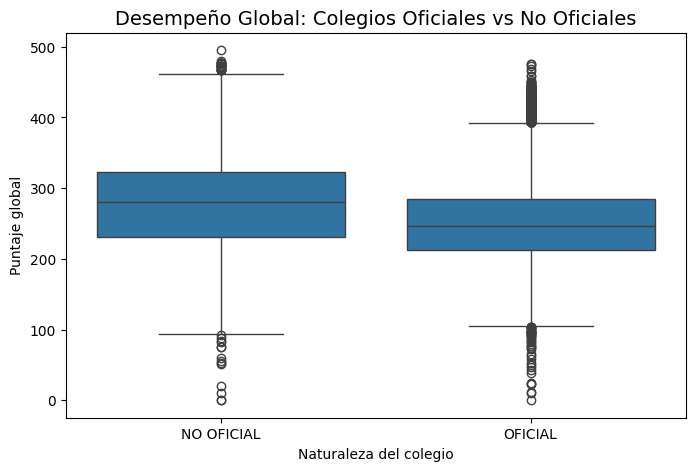

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(x="cole_naturaleza", y="punt_global", data=df_icfes_transformed)
plt.title("Desempeño Global: Colegios Oficiales vs No Oficiales", fontsize=14)
plt.xlabel("Naturaleza del colegio")
plt.ylabel("Puntaje global")
plt.show()

# 2. Diferencia entre estudiantes urbanos y rurales

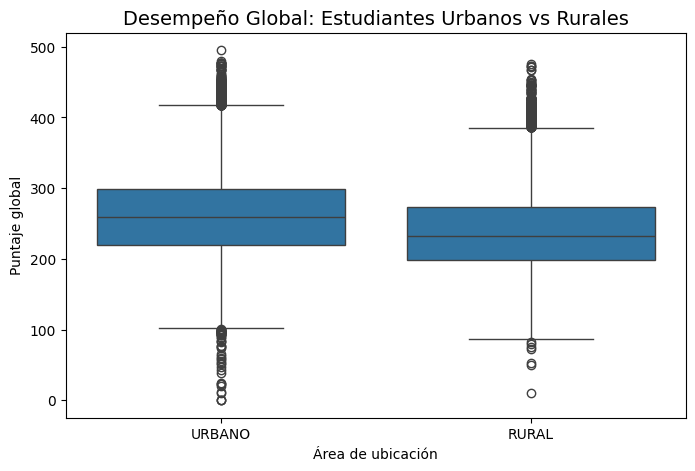

In [24]:
plt.figure(figsize=(8,5))
sns.boxplot(x="cole_area_ubicacion", y="punt_global", data=df_icfes_transformed)
plt.title("Desempeño Global: Estudiantes Urbanos vs Rurales", fontsize=14)
plt.xlabel("Área de ubicación")
plt.ylabel("Puntaje global")
plt.show()

# 3. Relación entre número de libros en el hogar y puntaje en lectura crítica

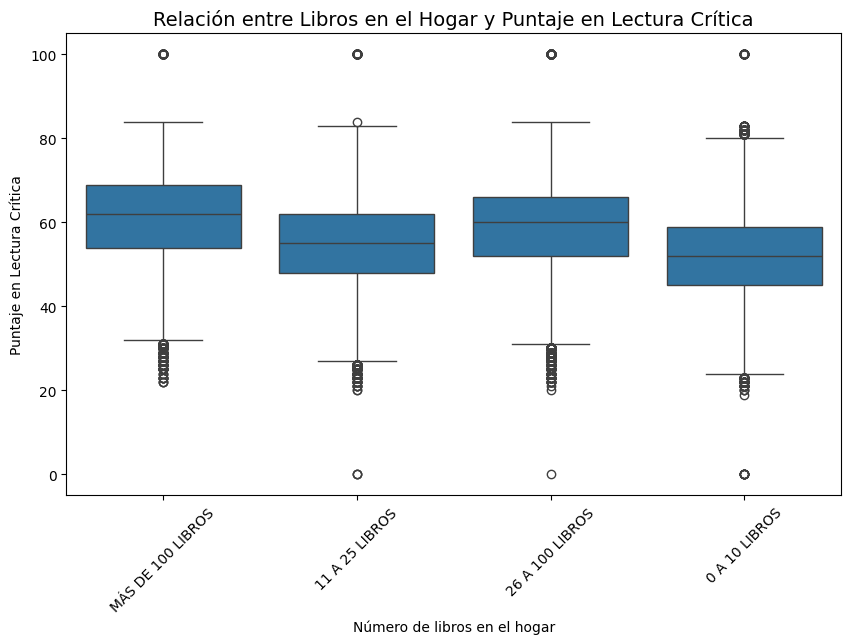

In [25]:
plt.figure(figsize=(10,6))
sns.boxplot(x="fami_numlibros", y="punt_lectura_critica", data=df_icfes_transformed)
plt.title("Relación entre Libros en el Hogar y Puntaje en Lectura Crítica", fontsize=14)
plt.xlabel("Número de libros en el hogar")
plt.ylabel("Puntaje en Lectura Crítica")
plt.xticks(rotation=45)
plt.show()

# 4. Impacto del acceso a internet en matemáticas y ciencias naturales

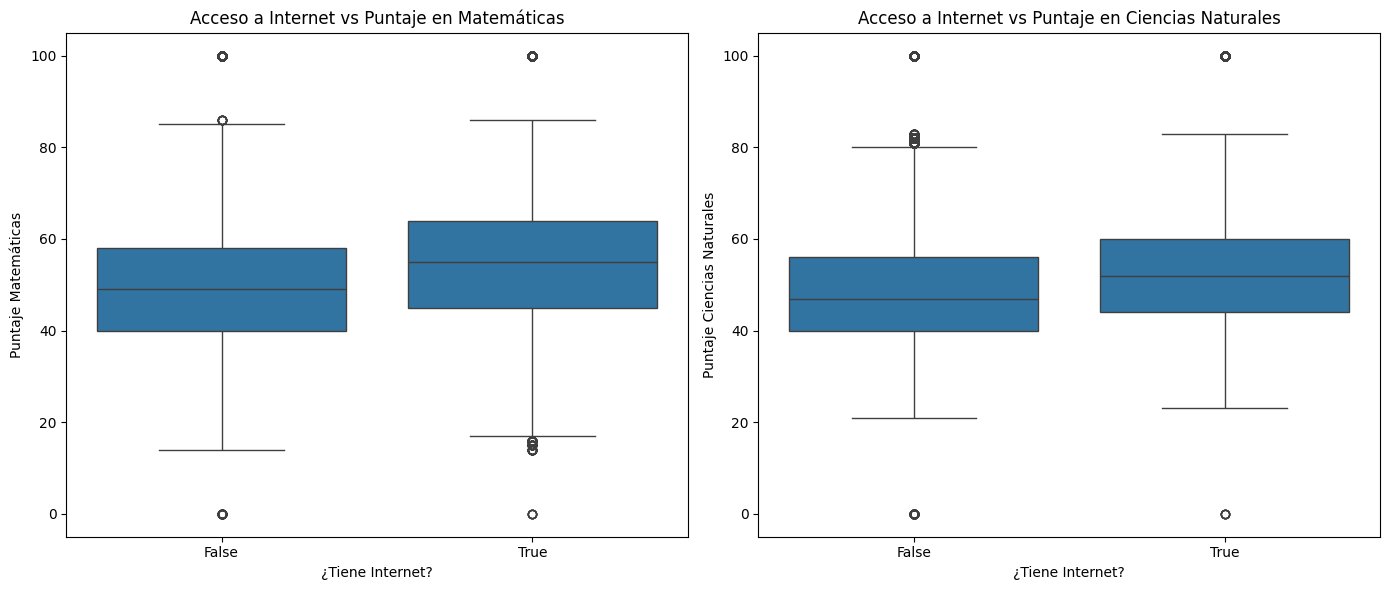

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.boxplot(x="fami_tieneinternet", y="punt_matematicas", data=df_icfes_transformed, ax=axes[0])
axes[0].set_title("Acceso a Internet vs Puntaje en Matemáticas")
axes[0].set_xlabel("¿Tiene Internet?")
axes[0].set_ylabel("Puntaje Matemáticas")

sns.boxplot(x="fami_tieneinternet", y="punt_c_naturales", data=df_icfes_transformed, ax=axes[1])
axes[1].set_title("Acceso a Internet vs Puntaje en Ciencias Naturales")
axes[1].set_xlabel("¿Tiene Internet?")
axes[1].set_ylabel("Puntaje Ciencias Naturales")

plt.tight_layout()
plt.show()

# 5. Impacto del estrato socioeconómico en el rendimiento académico

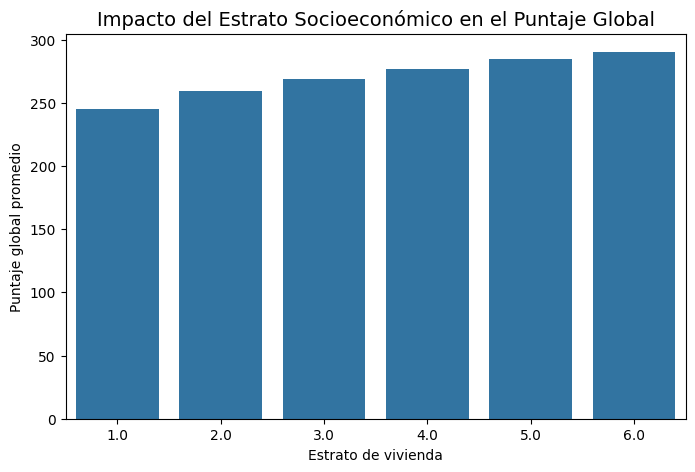

In [27]:
plt.figure(figsize=(8,5))
df_grouped = df_icfes_transformed.groupby("fami_estratovivienda")["punt_global"].mean().reset_index()

sns.barplot(x="fami_estratovivienda", y="punt_global", data=df_grouped)
plt.title("Impacto del Estrato Socioeconómico en el Puntaje Global", fontsize=14)
plt.xlabel("Estrato de vivienda")
plt.ylabel("Puntaje global promedio")
plt.show()

# 6. Puntaje de ingles en colegios y no bilingues

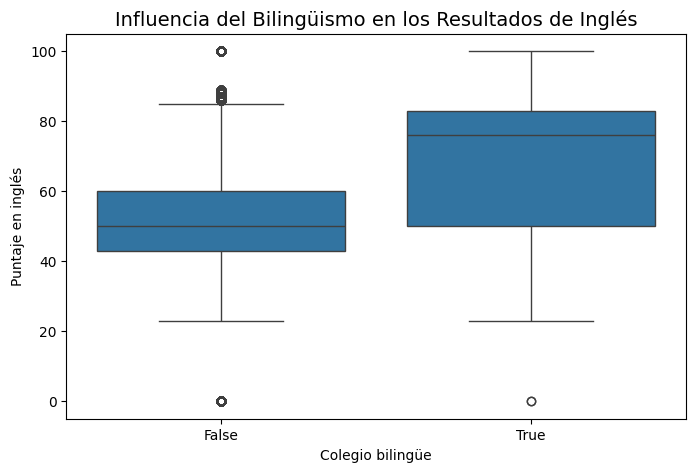

In [33]:
plt.figure(figsize=(8,5))
sns.boxplot(x="cole_bilingue", y="punt_ingles", data=df_icfes_transformed)
plt.title("Influencia del Bilingüismo en los Resultados de Inglés", fontsize=14)
plt.xlabel("Colegio bilingüe")
plt.ylabel("Puntaje en inglés")
plt.show()

# Análisis e Interpretaciones

Oficial vs No Oficial: Los colegios no oficiales logran mejores puntajes globales que los oficiales.

Urbano vs Rural: Los estudiantes urbanos superan en promedio a los rurales.

Libros en el hogar: Más libros se asocian con mejores resultados en lectura crítica.

Internet: Tener acceso a internet mejora los puntajes en matemáticas y ciencias naturales.

Estrato socioeconómico: A mayor estrato, mayor puntaje global promedio.

Bilingüismo: Los colegios bilingües muestran un rendimiento claramente superior en inglés.

# Dashboard

C:\Users\USER\AppData\Local\Temp\ipykernel_9780\3714918822.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha="right")


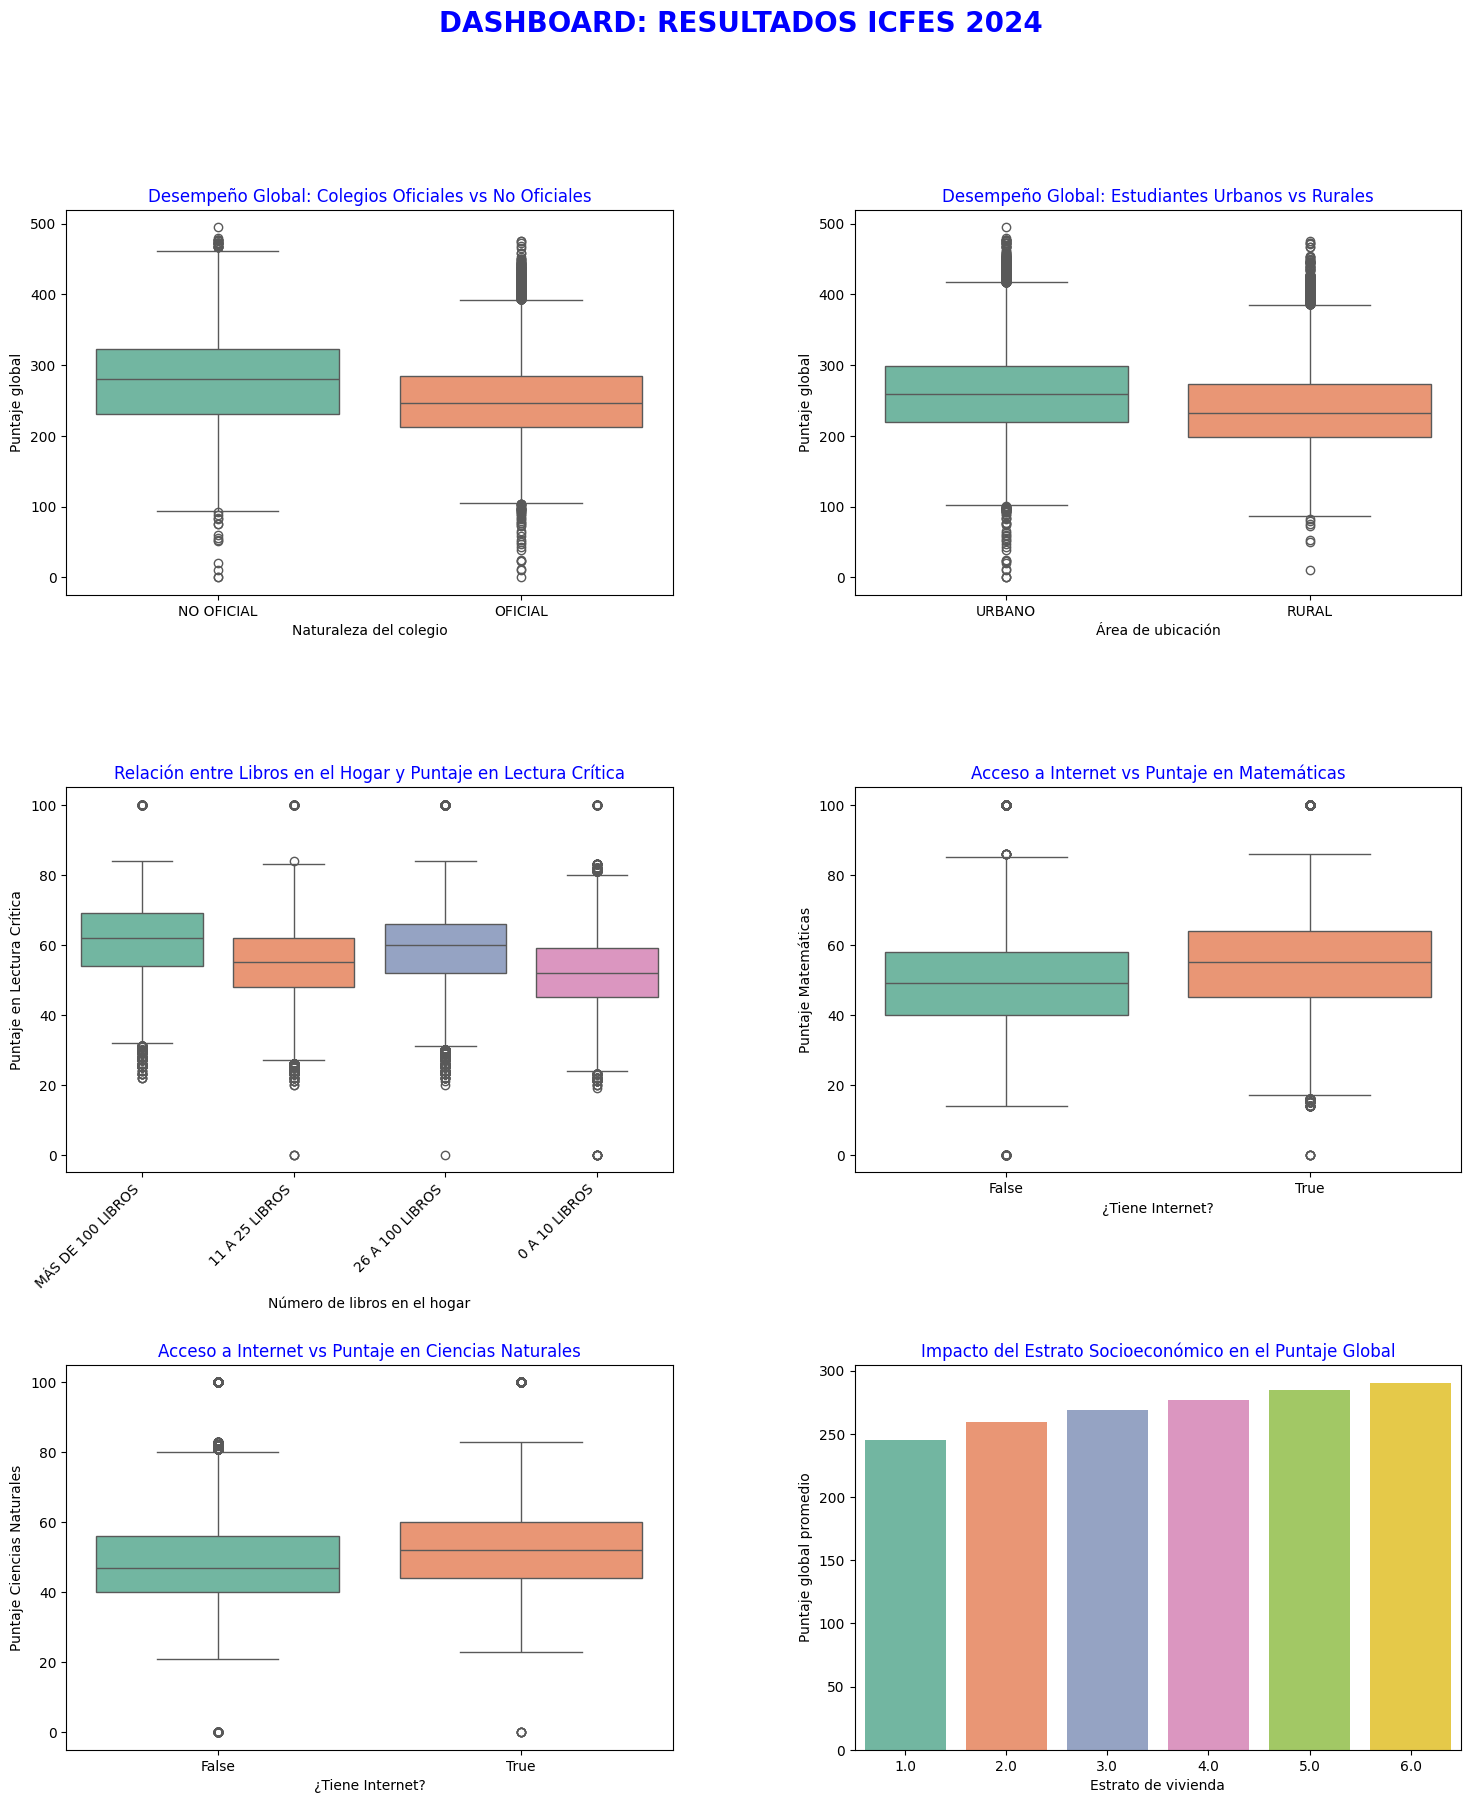

In [54]:
# Paleta de colores base
palette = sns.color_palette("Set2")

# Crear figura y layout (3 filas x 2 columnas)
fig = plt.figure(figsize=(18, 20))
gs = gridspec.GridSpec(3, 2, figure=fig)

# === Figura 1: Naturaleza del colegio ===
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(
    x="cole_naturaleza", y="punt_global",
    data=df_icfes_transformed,
    hue="cole_naturaleza", legend=False,  # <-- evita FutureWarning
    palette=sns.color_palette("Set2", df_icfes_transformed["cole_naturaleza"].nunique()), 
    ax=ax1
)
ax1.set_title("Desempeño Global: Colegios Oficiales vs No Oficiales", fontsize=12, color="blue")
ax1.set_xlabel("Naturaleza del colegio")
ax1.set_ylabel("Puntaje global")

# === Figura 2: Área de ubicación ===
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(
    x="cole_area_ubicacion", y="punt_global",
    data=df_icfes_transformed,
    hue="cole_area_ubicacion", legend=False,
    palette=sns.color_palette("Set2", df_icfes_transformed["cole_area_ubicacion"].nunique()),
    ax=ax2
)
ax2.set_title("Desempeño Global: Estudiantes Urbanos vs Rurales", fontsize=12, color="blue")
ax2.set_xlabel("Área de ubicación")
ax2.set_ylabel("Puntaje global")

# === Figura 3: Libros en el hogar ===
ax3 = fig.add_subplot(gs[1, 0])
sns.boxplot(
    x="fami_numlibros", y="punt_lectura_critica",
    data=df_icfes_transformed,
    hue="fami_numlibros", legend=False,
    palette=sns.color_palette("Set2", df_icfes_transformed["fami_numlibros"].nunique()),
    ax=ax3
)
ax3.set_title("Relación entre Libros en el Hogar y Puntaje en Lectura Crítica", fontsize=12, color="blue")
ax3.set_xlabel("Número de libros en el hogar")
ax3.set_ylabel("Puntaje en Lectura Crítica")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha="right")

# === Figura 4: Internet vs Matemáticas ===
ax4 = fig.add_subplot(gs[1, 1])
sns.boxplot(
    x="fami_tieneinternet", y="punt_matematicas",
    data=df_icfes_transformed,
    hue="fami_tieneinternet", legend=False,
    palette=sns.color_palette("Set2", df_icfes_transformed["fami_tieneinternet"].nunique()),
    ax=ax4
)
ax4.set_title("Acceso a Internet vs Puntaje en Matemáticas", fontsize=12, color="blue")
ax4.set_xlabel("¿Tiene Internet?")
ax4.set_ylabel("Puntaje Matemáticas")

# === Figura 5: Internet vs Ciencias Naturales ===
ax5 = fig.add_subplot(gs[2, 0])
sns.boxplot(
    x="fami_tieneinternet", y="punt_c_naturales",
    data=df_icfes_transformed,
    hue="fami_tieneinternet", legend=False,
    palette=sns.color_palette("Set2", df_icfes_transformed["fami_tieneinternet"].nunique()),
    ax=ax5
)
ax5.set_title("Acceso a Internet vs Puntaje en Ciencias Naturales", fontsize=12, color="blue")
ax5.set_xlabel("¿Tiene Internet?")
ax5.set_ylabel("Puntaje Ciencias Naturales")

# === Figura 6: Estrato socioeconómico ===
ax6 = fig.add_subplot(gs[2, 1])
df_grouped = df_icfes_transformed.groupby("fami_estratovivienda")["punt_global"].mean().reset_index()
sns.barplot(
    x="fami_estratovivienda", y="punt_global",
    data=df_grouped,
    hue="fami_estratovivienda", legend=False,
    palette=sns.color_palette("Set2", df_grouped["fami_estratovivienda"].nunique()),
    ax=ax6
)
ax6.set_title("Impacto del Estrato Socioeconómico en el Puntaje Global", fontsize=12, color="blue")
ax6.set_xlabel("Estrato de vivienda")
ax6.set_ylabel("Puntaje global promedio")

# Ajustar espacios
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Título general en azul
fig.suptitle("DASHBOARD: RESULTADOS ICFES 2024", fontsize=20, fontweight="bold", color="blue")

plt.show()